In [1]:
import numpy as np
import pandas as pd

from util import *

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import matthews_corrcoef, ConfusionMatrixDisplay, confusion_matrix
from tensorflow.keras import models, layers, losses, metrics, activations

In [2]:
df = pd.read_csv("./data/creditcard.csv").drop(columns="Time")

In [3]:
X, y = df.drop(columns="Class"), df.Class

In [4]:
y.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=225)

In [23]:
y_train.value_counts()

0    227446
1       399
Name: Class, dtype: int64

In [7]:
sc = MinMaxScaler().fit(X_train)

In [8]:
class Autoencoder(models.Model):
    def __init__(self, true, latent):
        super(Autoencoder, self).__init__()
        self.encoder = models.Sequential([
            layers.Dense(latent, activation="tanh")
        ], name="encoder")
        
        self.decoder = models.Sequential([
            layers.Dense(true, activation="sigmoid")
        ])
        
    def call(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return dec

In [25]:
ae = Autoencoder(29, 10)

In [26]:
ae.compile("adam", loss="mse")

In [46]:
ae.fit(
    sc.transform(X_train), 
    sc.transform(X_train), 
    batch_size=128, 
    epochs=2, 
    validation_data=(sc.transform(X_test), sc.transform(X_test))
)

Epoch 1/2
1781/1781 [==============================] - 9s 5ms/step - loss: 3.0618e-04 - val_loss: 3.1247e-04
Epoch 2/2
1781/1781 [==============================] - 9s 5ms/step - loss: 3.0371e-04 - val_loss: 3.1188e-04


### Encoder Representation for SVM

In [47]:
X_train_=ae.encoder(sc.transform(X_train))

In [48]:
X_test_ = ae.encoder(sc.transform(X_test))

In [49]:
svc = SVC().fit(X_train_, y_train)
preds = svc.predict(X_test_)
matthews_corrcoef(y_test, preds)

0.8163910708851516

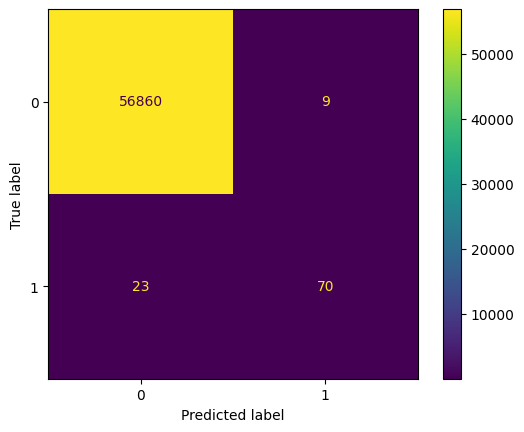

In [50]:
ConfusionMatrixDisplay(confusion_matrix(y_test,preds)).plot()

### Encoder Representation for feedforward network

In [51]:
ae.encoder.trainable=False

In [52]:
model = models.Sequential([
    ae.encoder,
    layers.Dense(15, "relu"),
    layers.Dense(1, "sigmoid")
])

In [53]:
model.compile(loss="binary_crossentropy", metrics=[metrics.Recall()])

In [60]:
model.fit(
    sc.transform(X_train), y_train,
    batch_size=256,
    epochs=2,
    validation_data=( sc.transform(X_test), y_test )
)

Epoch 1/2
891/891 [==============================] - 8s 9ms/step - loss: 0.0043 - recall: 0.6491 - val_loss: 0.0033 - val_recall: 0.7312
Epoch 2/2
891/891 [==============================] - 7s 8ms/step - loss: 0.0042 - recall: 0.6541 - val_loss: 0.0032 - val_recall: 0.7419


In [61]:
preds = (np.array(model(sc.transform(X_test)))>=0.5)*1
matthews_corrcoef(y_test, preds)

0.794686357714332

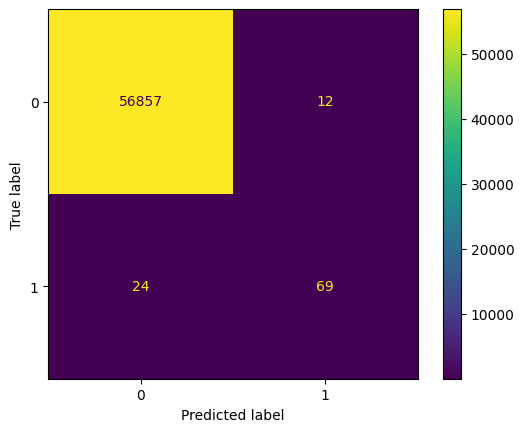

In [62]:
ConfusionMatrixDisplay(confusion_matrix(y_test,preds)).plot()